我在一开始学习数据科学中[机器学习(Machine Learning)](https://zh.wikipedia.org/wiki/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0)的时候重点都放在理解每个模型上，但是真的到用机器学习去解决问题的时候发现自己完全没有思路。所以今天的主要目的是**用一个简单的例子和大家分享下使用Python的三方包sklean解决机器学习的思路。**

文中使用了Kaggle上著名的[Titanic数据集](https://www.kaggle.com/c/titanic)，主要利用了Python三方包pandas，sklearn，和matloplib对数据集进行了数据分析，可视化和建立分类模型(Classification model)预测乘客是否存活。主要的步骤为：

1. 提出、理解问题
2. 导入、理解数据
3. 数据清洗
4. 数据分析与可视化
5. 特征工程
6. 建模预测
    * 选择评估指标
    * 数据预处理
    * 数据降维
    * 调参与模型评估
7. 方案实施
8. 总结

# 提出、理解问题

数据集分为2个文件：train.csv和test.csv。

train.csv可称做样本数据([in-sample data](https://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts))或训练数据，在训练数据中的Survived是目标变量(target variable，即模型的输出变量)，其他变量可以称为特征变量(feature，即模型的输入变量)。训练数据用来分析，并训练一个分类模型([Classification Model](https://towardsdatascience.com/machine-learning-classifiers-a5cc4e1b0623))。使用分类模型是因为目标变量是类别数据(Categorical Data)，即存活和死亡。

test.csv可以称作样本外数据(out-of-sample data)或测试数据，测试数据中只有特征变量而没有目标变量。在本例中用我们训练的模型来预测结果，并上传到kaggle评估模型的表现。


![数据集信息](img/titanic_dataset_descri.png)

这个项目主要有2个目的：

* 数据分析与可视化：利用数据展现信息，和讲述数据背后的故事。
* 建立分类模型预测是否存活：使用sklearn进行数据预处理、特征选择、模型训练和评估后，选择最优模型对测试数据进行预测，并上传到kaggle查看模型表现。

# 导入、理解数据

In [1]:
# 导入数据包，一般习惯在分析开头导入所有数据包。
# 数据处理与可视化
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pylab import mpl
import seaborn as sns
sns.set_theme(style='darkgrid') # 设置风格使图标更美观
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定字体雅黑，使图标可以显示中文
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

# 建模
from sklearn import set_config
set_config(display = 'diagram')
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# 导入数据
# 文件路经
path = r'/mnt/data-ubuntu/Projects/data_science_chinese'
train = pd.read_csv(path + r'/input/titanic/train.csv')
test = pd.read_csv(path + r'/input/titanic/test.csv')

In [3]:
# 查看数据前两行
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
# 查看test前两行
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [5]:
# 查看2个数据集基本信息。
print(f'train的数据大小：{train.shape}')
print(train.info())
print('='*40)
print(f'test的数据大小：{test.shape}')
print(test.info())

train的数据大小：(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
test的数据大小：(418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

与train不同的是，test没有Survived这一列，因为这一列需要我们通过模型预测出每一行对应的Survived值。

我们接下来看下2个数据集中的缺失值。

In [6]:
# 检查train中缺失值
s_temp = train.isnull().sum()
print(s_temp[s_temp>0])

Age         177
Cabin       687
Embarked      2
dtype: int64


In [7]:
# 检查test中缺失值
s_temp = test.isnull().sum()
print(s_temp[s_temp>0])

Age       86
Fare       1
Cabin    327
dtype: int64


In [8]:
# 查看train中目标变量的分布
train.groupby('Survived')['PassengerId'].nunique()

Survived
0    549
1    342
Name: PassengerId, dtype: int64

初步地了解数据后，我们得到以下信息：

* train有891行，而test有418行。数据量较小，在模型选择时需要选择在数据量小时训练结果较好的模型。
* 需要改变数据类型，Pclass, Sex, Cabin, Embarked应改为类属特征(categorical feature)。
* 在train和test中Age和Cabin都存在大量缺失值，此外在train中Embarked有2个缺失值，而test中Fare有1个缺失值，我们在数据清理阶段需要处理这些缺失值。
* Name包含较多信息，考虑是否可以用来生成更多信息。

# 数据清洗

根据对数据集的简单理解，数据清洗分为以下几步：

* 缺失值处理
* 数据类型转换
* 异常值处理

## 缺失值处理

要处理缺失值的原因是，缺失值会使计算、可视化、或有些模型的应用发生错误。
处理缺失值有多种方法：一般常用方法分为2类1.直接删除缺失行或列。2.补全缺失值([Imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)#:~:text=In%20statistics%2C%20imputation%20is%20the,known%20as%20%22item%20imputation%22.))。

由于这个数据集数量小，我们要通过对数据的分析尽可能地补全数据。首先，为了方便后面数据处理，我们先合并train和test。

In [9]:
# 合并train和test方便数据处理
df_data = pd.concat([train, test])
# 抛弃index的列PassengerId
df_data.drop('PassengerId', axis = 1, inplace = True)

In [10]:
# 合并后缺失值汇总
s_temp = df_data.isnull().sum()
print(s_temp[s_temp>0])

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64


test中没有Survived列，所以合并后有418个缺失值。Fare和Embarked缺失值较少，而Age和Cabin的缺失值较多。

**补全Embarked**

In [11]:
# Embarked
df_data[df_data.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


我们注意到Embarked缺失的行Pclass是1，Fare是80。可以通过分析Embarked，Fare和Pclass的关系推测Embarked的可能值。

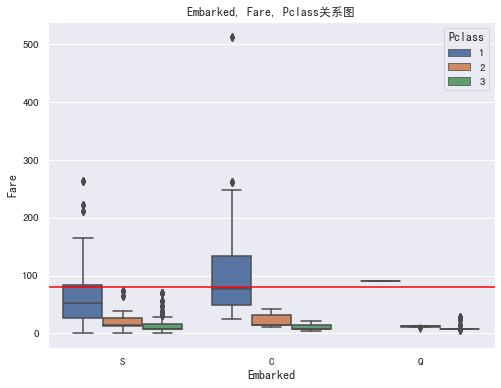

In [12]:
# 可视化数据方便观察数据
plt.figure(figsize=(8,6))
g = sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data=df_data)
g.axhline(80, color = 'red')
plt.title('Embarked, Fare, Pclass关系图')
plt.show()

从上图展示了不同Embarked和Pclass下Fare的分布情况(红线表示Fare=80)，可以看出Pclass=1，Fare=80时Embarked=C的概率最大。所以缺失的Embarked补全为'C'。

In [13]:
# 补全Embarked
df_data.Embarked.fillna('C', inplace = True)

**补全Fare**

Fare只有一个缺失值，我们先看看Fare的统计学信息。

In [14]:
df_data['Fare'].describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

Fare平均值为33.3而最大值却有512.3，最大值会极大影响平均值，因此选择中位数补全更合理。

In [15]:
# 补全Fare
df_data.Fare.fillna(df_data.Fare.median(), inplace = True)

**补全Cabin**

Cabin包含大量缺失值，所以我采取的措施是用U(Unknown)补全缺失值。

In [16]:
# 补全Cabin
df_data.Cabin.fillna('U', inplace = True)

In [17]:
# 合并后缺失值汇总
s_temp = df_data.isnull().sum()
print(s_temp[s_temp>0])

Survived    418
Age         263
dtype: int64


**补全Age**

Age包含263个缺失值，对于如此多的缺失值，我们可以选择用模型去估计缺失值，但在本例中用模型估计不是本文的重点，因此选择简单的中位数补全。

In [18]:
# 补全Age
df_data.Age.fillna(df_data.Age.median(), inplace = True)

## 数据类型转换

In [19]:
df_data['Survived'] = df_data['Survived'].astype('category')
df_data['Pclass'] = df_data['Pclass'].astype('category')
df_data['Sex'] = df_data['Sex'].astype('category')
df_data['Embarked'] = df_data['Embarked'].astype('category')

## 异常值处理

我们注意到Fare有离群值512.33。数据中有4个人是同一张票，如果除以4，人均票价还算合理。此外，因为数据总少在这里我不做任何操作。

In [20]:
df_data[df_data['Fare'] > 300]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,1.0,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,U,C
679,1.0,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,1.0,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
343,NaN,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


# 数据分析与可视化

这一步的目的是分析、探索数据并可视化(EDA, [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis#Techniques_and_tools))，从而有助于揭示数据隐藏的信息(趋势，变量之间的关系等)，或为特征工程([feature engineering](https://en.wikipedia.org/wiki/Feature_engineering#:~:text=Feature%20engineering%20is%20the%20process,as%20applied%20machine%20learning%20itself.))提供更多依据。

我们探索下以下特征关系：

* Pclass VS Survived
* Sex VS Survived
* Embarked VS Survived
* SibSp VS Survived
* Parch VS Survived
* Age VS Survived
* Fare VS Survived


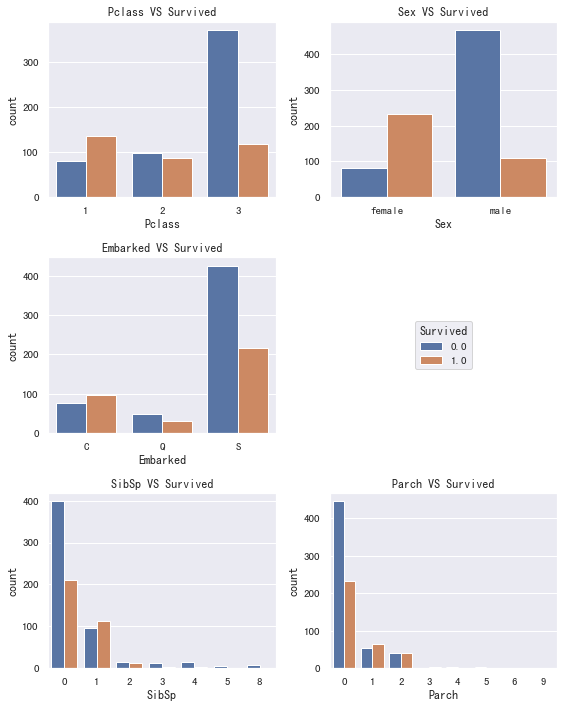

In [21]:
# 绘制Pclass,Sex,Embarked,SibSp,Parch与Survived关系图
fig, ax = plt.subplots(3, 2, figsize=(8,10))
ax[1, 1].axis('off')

# Pclass VS Survived
sns.countplot(x = 'Pclass', hue = 'Survived',
              data = df_data, ax = ax[0, 0])
ax[0, 0].set_title('Pclass VS Survived')
ax[0, 0].get_legend().remove()

# Sex VS Survived
sns.countplot(x = 'Sex', hue = 'Survived',
              data = df_data, ax = ax[0, 1])
ax[0, 1].set_title('Sex VS Survived')
ax[0, 1].get_legend().remove()

# Embarked VS Survived
sns.countplot(x = 'Embarked', hue = 'Survived',
              data = df_data, ax = ax[1, 0])
ax[1, 0].set_title('Embarked VS Survived')
ax[1, 0].get_legend().remove()

# SibSp VS Survived
sns.countplot(x = 'SibSp', hue = 'Survived',
              data = df_data, ax = ax[2, 0])
ax[2, 0].set_title('SibSp VS Survived')
ax[2, 0].get_legend().remove()

# Parch VS Survived
sns.countplot(x = 'Parch', hue = 'Survived',
              data = df_data, ax = ax[2, 1])
ax[2, 1].set_title('Parch VS Survived')
ax[2, 1].get_legend().remove()

handles, labels = ax[0,0].get_legend_handles_labels()
ax[1, 1].legend(handles, labels, title = 'Survived', loc = 10)
fig.tight_layout()
plt.show()

从上图我们得到以下信息：

* 越好的客仓等级(class)生存率越高，其中1和2的生存率相差不大，但客仓等级3的生存率相比其他等级大幅降低。
* 女性的生存率大于男性，这也与电影中“让女人和小孩先走”吻合。
* 从港口S上船的生存率最低，从C上船的生存率最高，超过半数C上船的人存活了。
* 单身的人(SibSp+Parch = 0)存活率低于有家庭的存活率。

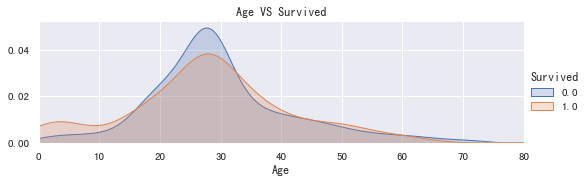

In [22]:
# 绘制Age与Survived关系图
g = sns.FacetGrid(df_data, hue = 'Survived', height = 2.5, aspect=3)
g.map(sns.kdeplot, 'Age', shade= True )
g.set(xlim=(0 , df_data['Age'].max()))
g.add_legend()
plt.title('Age VS Survived')
plt.show()

从Age和Survived的关系图中我们得到以下信息：

* 未成年人生存率高于成年人，这也与电影中“让女人和小孩先走”吻合。

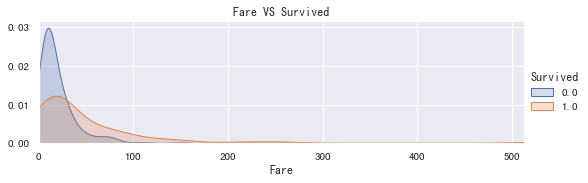

In [23]:
# 绘制Fare与Survived关系图
g = sns.FacetGrid(df_data, hue = 'Survived', height = 2.5, aspect=3)
g.map(sns.kdeplot, 'Fare', shade= True )
g.set(xlim=(0 , df_data['Fare'].max()))
g.add_legend()
plt.title('Fare VS Survived')
plt.show()

从上图我们得到以下信息：

* 票价越高生还几率越高。
* 有票价超过500，也许是离群值。

# 特征工程

特征工程(Feature Engineering)是指从现有变量中通过数据挖掘生成新变量，这些新变量可用于提高模型的预测准确度。通过数据分析与可视化，我们可以生成以下新变量：

* familySize: 船上每个人的家庭大小等于SibSp+Parch+1。
* isAlone: 船上仅有自己一人，即familySize = 1。
* singleFare: 有些船票价格是一个人的价格，通过Fare/familySize计算出对应每个人的船票价格。
* nameLen: 名字(Name)的长度。
* Cabin: 只获取字母
* title: 从name中分离出头衔信息。

In [24]:
#familySize
df_data['familySize'] = df_data['SibSp'] + df_data['Parch'] + 1
#isAlone
df_data['isAlone'] = (df_data['familySize'] == 1).astype('category')
#singleFare
df_data['singleFare'] = df_data['Fare']/df_data['familySize']
# nameLen
df_data['nameLen'] = df_data['Name'].str.len()
# Cabin
df_data['Cabin'] = df_data['Cabin'] \
                    .map(lambda x: re.search('\D',x, re.IGNORECASE).group(0)) \
                    .astype('category')

这里比较复杂的特征是Name，它包含较多信息，我们先随机看10条找找规律。

In [25]:
df_data['Name'].sample(10)

162                                 Wright, Miss. Marion
730                        Allen, Miss. Elisabeth Walton
372                           Beavan, Mr. William Thomas
72                        Nieminen, Miss. Manta Josefina
260                 de Messemaeker, Mr. Guillaume Joseph
639                           Thorneycroft, Mr. Percival
230         Harris, Mrs. Henry Birkhardt (Irene Wallach)
198                     Madigan, Miss. Margaret "Maggie"
842                              Serepeca, Miss. Augusta
323    Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...
Name: Name, dtype: object

我们发现Name是由名+头衔+姓组成的，那就看下有哪些头衔。

In [26]:
# 拆分名，头衔，姓得到所有头衔
df_data['title'] = df_data.Name.map(lambda x: re.split(', |\. ',x)[1])
# 查看每个title的个数
df_data.groupby('title').count()['Ticket'].sort_values()

title
Capt              1
Mme               1
Sir               1
Lady              1
Jonkheer          1
the Countess      1
Dona              1
Don               1
Major             2
Mlle              2
Ms                2
Col               4
Rev               8
Dr                8
Master           61
Mrs             197
Miss            260
Mr              757
Name: Ticket, dtype: int64

有些title是重复的，只是不同国家或地区表示title的方法不同，比如Ms,Miss同指Miss。此外，有些title非常少，可以合并为一类rare。

In [27]:
# 需要查询每个title是否有对应值比如Mme和Ｍrs是同一个意思。
dict_title = {'Capt': 'rare', 'Mme': 'Mrs', 'Lady': 'rare', 'Lady': 'rare',
              'Jonkheer': 'rare', 'the Countess': 'rare', 'Dona': 'Mrs',
              'Don': 'rare', 'Major': 'rare', 'Mlle': 'Miss', 'Ms': 'Miss',
              'Col': 'rare', 'Rev': 'rare', 'Dr':'rare', 'Sir': 'rare'}
# 根据dict_title替换title
df_data['title'] = df_data['title'].map(lambda x: dict_title.get(x, x)).astype('category')

# 建模预测

建立模型对test数据进行预测是我们项目的第二个目的。使用所有train数据，进行数据预处理，数据降维，并训练比较模型得到最优模型进行预测。

In [28]:
# 首先移除不需要的列
to_drop = ['Name', 'Ticket']
df_data.drop(to_drop, axis = 1, inplace = True)

# 拆分train和test
train = df_data[~df_data['Survived'].isnull()].copy()
test = df_data[df_data['Survived'].isnull()].iloc[:, 1:].copy()

# 分开X与y
X = train.iloc[:, 1:]
y = train.iloc[:, 0]

## 选择评估指标

建立模型前，首先需要选择评估指标，指标用于量化模型预测能力的好坏。对于不同的预测目的需要选择相应的评估指标，比如预测类别使用AUC, confusion matrix, log loss等;回归预测则使用MAE，R-Squared，MAPE等。对于指标选择的问题可以参考[这篇文章](https://www.kaggle.com/vipulgandhi/how-to-choose-right-metric-for-evaluating-ml-model)。

根据kaggle上的说明，titanic预测结果需要用[accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)，即正确预测率：正确预测数/总预测数。

## 数据预处理

模型数据预处理是指对数据进行特征缩放([Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling))或对类别数据的编码([Encoding](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/))。通过数据预处理后，减小了极值对模型准确度的影响；使得类别数据可以运用于某些模型，从而提高预测准确率。

对与titanic数据我们采取以下预处理：

* 对非类别数据如Age, singleFare等进行[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler)处理。
* 对所有类别数据(category)进行[OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehotencod#sklearn.preprocessing.OneHotEncoder) 处理

In [29]:
# 所有非category列
col_s = X.dtypes[~(X.dtypes == 'category')].index.tolist()
# 所有category列
col_c = X.dtypes[(X.dtypes == 'category')].index.tolist()
col_trans = make_column_transformer((StandardScaler(), col_s),
                                    (OneHotEncoder(handle_unknown='ignore'), col_c),
                                    remainder = 'passthrough')

## 数据降维

简单来说，数据降维([dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction))就是只选择一些特征作为输入，或者合并特征后输入模型的特征。因为过多的特征会导致模型预测准确率下降或者过拟合([overfitting](https://en.wikipedia.org/wiki/Overfitting))。一般常用的特征选择主要分为三类：Filter Methods，Ｗrapper Methods，Embeded Methods。因为特征选择不是本文重点，有兴趣的同学可以阅读[这篇文章](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/)。

对于titanic数据集，我们使用模型选择特征。利用[SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html?highlight=select%20from%20model#sklearn.feature_selection.SelectFromModel)和[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)对训练数据集进行训练后，得到每个特征对于预测的重要性(重要性可以理解为训练后每个特征得到一个分数，分数越高特征越重要。)排序，然后根据重要性排序选择前n个特征作为后面模型训练的输入特征。

这里我使用了sklearn中的[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)构建一个模型预处理，特征选择，模型训练的整体流程。这样在与测试集数据(test)预测的时候，我不需要再重复数据预处理和模型选择的步骤。

In [30]:
pipeline = Pipeline([('preprocessing', col_trans),
                     ('feat_selection', SelectFromModel(LogisticRegression(),
                                                        threshold=-np.inf,
                                                        max_features = 30)),
                     ('model', RandomForestClassifier())])

In [31]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'familySize',
                                                   'singleFare', 'nameLen']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pclass', 'Sex', 'Cabin',
                                                   'Embarked', 'isAlone',
                                                   'title'])])),
                ('feat_selection',
                 SelectFromModel(estimator=LogisticRegression(),
                                 max_features=30, threshold=-inf)),
                ('model', RandomForestClassifier())])

从pipeline的步骤图可以看出，对于数据集我们先进行数据预处理－preprocessing，对于类别数据使用了OneHotEncorder，而对数值型数据进行了StandardScaler。其次，使用模型LogisticRegression进行了特征的选择－feat_selection。最后，用一个模型训练数据，得到最终模型。

需要注意的是这里RandomForestClassifier是可以替换成其他模型的，在调参与模型评估中，我们会看到如何比较不同模型的预测表现。

## 调参与模型评估

机器学习中调参就是从一系列参数组合中找到最优参数组，使得模型的评估指标最高。

在我们建立了Pipline后，它其实就相当于一个模型。这个模型同时包含了数据预处理，特征选择和分类模型。所以我们可以对Pipline这个模型进行优化，比如改变特征选择(feat_selection)这一步的特征选择个数(max_features)，使用不同分类模型(Pipline中的model)或者改变对应模型的超参数([hyperparameter](https://medium.com/@jorgesleonel/hyperparameters-in-machine-deep-learning-ca69ad10b981))等。

基于这个理解，我们先建立一个search_grid的列表包含了所有的超参数和模型的组合。列表中每个元素是一个字典，其中字典的key是Pipeline中的步骤名，比如"model"或者加上两个下划线(\_\_)代表了一个超参数，比如"model_C"，而value是我们需要搜索的值的列表。这样就构成了一个Pipeline所有超参数的搜索组合。

其次，我们使用[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)尝试所有search_grid中的组合，并从中找到评估指标(accuracy)最高的模型和它的超参数作为最终模型。

值得注意的是GridSearchCV中的参数cv使用的是[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)，这意味着在训练过程中每次训练集合会被分成默认的5份，有4份作为训练集，而剩下的一份作为测试集来检测模型的预测准确度，并且每一份中存活和死亡的比率都和整个训练集的比例相同。对于为什么要把所有训练数据分为训练集和测试集，或者什么是K Fold Cross-Validation请阅读[这篇文章](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=The%20train%2Dtest%20split%20is,dividing%20it%20into%20two%20subsets.)，以及[这篇](https://en.wikipedia.org/wiki/Cross-validation_(statistics))。

这里我们会训练4种不同的模型并评估它们的预测准确度(accuracy)。对于每个模型的理解不是本文的目的，有兴趣的同学可以阅读以下相关文章。

* [Logistic Regression](https://machinelearningmastery.com/logistic-regression-for-machine-learning/)
* [Decision Tree Classifier](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)
* [K Neighbors Classifier](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)
* [Random Forest Classifier](https://www.datacamp.com/community/tutorials/random-forests-classifier-python)



In [32]:
search_grid = [{'feat_selection__max_features': range(15,26),
                'model': [LogisticRegression()],
                    'model__C': [0.01,0.1,1.0]},
               {'feat_selection__max_features': range(15,26),
                'model': [DecisionTreeClassifier()],
                    'model__max_depth':list(range(1, 10)) + [None],
                    'model__max_leaf_nodes':[5, 10, 15, None],
                    'model__min_samples_leaf':[1, 5, 10, 15], 
                    'model__min_samples_split':[2, 3, 4]},
               {'feat_selection__max_features': range(15,26),
                'model': [KNeighborsClassifier()],
                    'model__n_neighbors':[3, 5, 7, 9],
                    'model__weights':['uniform', 'distance']},
               {'feat_selection__max_features': range(15,26),
                'model': [RandomForestClassifier()],
                    'model__max_depth':list(range(1, 10)) + [None],
                    'model__n_estimators':[20,40,60,80,100,120,140]}]

clf = GridSearchCV(pipeline, search_grid,
                   cv = StratifiedKFold(),
                   scoring = 'accuracy',
                   n_jobs = -1,
                   verbose = 1)
# GridSearchCV自动使用最优模型和参数对所有数据进行训练。
clf = clf.fit(X, y)

Fitting 5 folds for each of 6171 candidates, totalling 30855 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2840 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 4640 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 6840 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 9440 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 12440 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 15840 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 19640 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 23840 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 28440 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 30855 out of 30855 | elapsed:  2.9min finished


In [33]:
# 查看最优参数
clf.best_params_

{'feat_selection__max_features': 18,
 'model': RandomForestClassifier(max_depth=7),
 'model__max_depth': 7,
 'model__n_estimators': 100}

In [34]:
# 查看最优模型的accuracy。
clf.best_score_

0.8383780051471972

# 方案实施

在模型建立后，使用最终模型对测试集(test)进行预测，并保存到一个csv文件中。

In [35]:
y_pred = clf.predict(test)
df_result = pd.DataFrame({'PassengerId': range(892, len(y_pred)+892), 'Survived': y_pred})
df_result['Survived'] = df_result['Survived'].astype('int')
df_result.to_csv(path + r'/output/randomForest_submission.csv', index = False)

生成csv文件后，进入[Kaggle Titanic预测提交界面](https://www.kaggle.com/c/titanic/submit)。

![titanic_sub1](img/titanic_sub1.png)

点击上传图标选择生成的csv结果，然后点击页面底部的“Make Submission”。

![titanic_sub2](img/titanic_sub2.png)

在点击上传后，就会出现你的预测准确度。你也可以点击“Jump to your position on the leaderboard”查看你的排名。

![titanic_sub3](img/titanic_sub_score.png)

# 总结

这篇文章我们学习了使用Python和sklearn进行机器学习的流程框架，主要内容包括了：

* 使用pandas进行数据清洗，对数据类型的转换，和处理缺失值和异常值。
* 使用matplotlib和seabron进行可视化分析，展示数据的隐藏信息。
* 基于对数据的理解进行特征工程，生成新的特征用于提高模型准确度。
* 讨论了模型训练一般步骤：选择评估指标，数据预处理，数据降维，和模型的调参与选择。
* 使用sklearn的pipeline整合特征预处理，特征选择和训练模型；利用GridSearchCV自动化模型调参和评估。

当然，我们可以进一步提高模型的预测准确度。比如特征工程生成更多特征，使用其他方式选择特征，采用更强大的模型和尝试更多的超级参数。这些问题就留给不断学习的你去完成。

感谢阅读！